In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau,LearningRateScheduler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/sample_submission.csv


/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [2]:
train = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/test.csv")

In [3]:
y_train=train['label']
x_train=train.drop(labels='label', axis=1)
print("Trainig shape : {} ".format(x_train.shape))
print("label shape : {} ".format(y_train.shape))
print("Testing shape : {} ".format(test.shape))

Trainig shape : (42000, 784) 
label shape : (42000,) 
Testing shape : (28000, 784) 


In [4]:
print("null values in training : {}".format(x_train.isnull().any().sum()))
print("null values in testing : {}".format(test.isnull().any().sum()))

null values in training : 0
null values in testing : 0


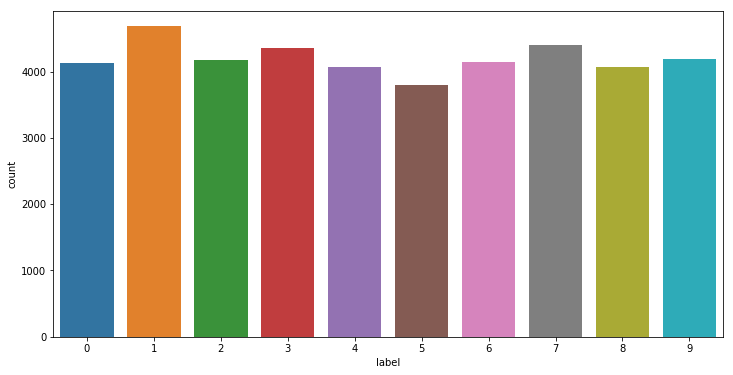

In [5]:
# plot the number of counts
fig = plt.figure(figsize=(12,6))
sns.countplot(y_train);

In [6]:
# Normalize the data
x_train = x_train / 255.0
x_test = test / 255.0
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
x_train = x_train.values.reshape(-1,28,28,1)
x_test = x_test.values.reshape(-1,28,28,1)
# reduce the size of datatypes for fater computaions
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
# convert label into one hot encoding
y_train = to_categorical(y_train)

In [7]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=2)

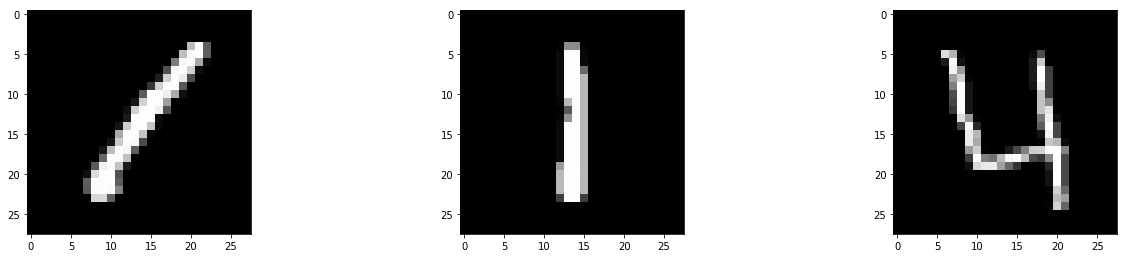

In [8]:
# plot some of digits
fig = plt.figure(figsize=(22,14) )
ax1 = fig.add_subplot(331)
plt.imshow(x_train[0][:,:,0], cmap=plt.get_cmap('gray'))
ax2 = fig.add_subplot(332)
plt.imshow(x_train[2][:,:,0], cmap=plt.get_cmap('gray'))
ax3 = fig.add_subplot(333)
plt.imshow(x_train[3][:,:,0], cmap=plt.get_cmap('gray'))
fig.show()

In [9]:
# initialize model
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', input_shape = (28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [10]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [11]:
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"])
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [12]:
history  = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=16),
                           steps_per_epoch=500,
                           epochs=10, 
                           verbose=2,  
                           validation_data=(X_val,Y_val), 
                           callbacks=[annealer])

Epoch 1/10
 - 19s - loss: 0.8445 - acc: 0.7323 - val_loss: 0.1943 - val_acc: 0.9436
Epoch 2/10
 - 18s - loss: 0.3342 - acc: 0.8991 - val_loss: 0.1200 - val_acc: 0.9676
Epoch 3/10
 - 18s - loss: 0.2444 - acc: 0.9265 - val_loss: 0.0768 - val_acc: 0.9779
Epoch 4/10
 - 17s - loss: 0.1929 - acc: 0.9424 - val_loss: 0.0799 - val_acc: 0.9793
Epoch 5/10
 - 18s - loss: 0.1744 - acc: 0.9481 - val_loss: 0.0724 - val_acc: 0.9771
Epoch 6/10
 - 17s - loss: 0.1754 - acc: 0.9487 - val_loss: 0.0641 - val_acc: 0.9810
Epoch 7/10
 - 18s - loss: 0.1317 - acc: 0.9617 - val_loss: 0.0544 - val_acc: 0.9814
Epoch 8/10
 - 17s - loss: 0.1329 - acc: 0.9605 - val_loss: 0.0468 - val_acc: 0.9871
Epoch 9/10
 - 18s - loss: 0.1322 - acc: 0.9615 - val_loss: 0.0396 - val_acc: 0.9895
Epoch 10/10
 - 18s - loss: 0.1165 - acc: 0.9661 - val_loss: 0.0500 - val_acc: 0.9860


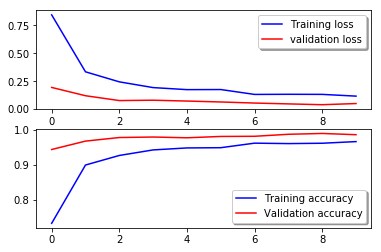

In [13]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [14]:
# predict testing set
predictions = model.predict_classes(x_test, verbose=0)

In [15]:
# create dataframe
values = {'ImageId': np.arange(1,28001), 'Label': predictions}
submission=pd.DataFrame(data=values)
submission.to_csv("mnist_submission.csv",index=False)